# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
import numpy as np

C:\Users\TRIEU\AppData\Local\Temp\ipykernel_12880\2686212071.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Import Data

In [2]:
edge = pd.read_csv('site.csv')
# user = pd.read_csv('users-aus.csv')
user = pd.read_csv('User_Full_Quan.csv')

In [3]:
# user['Size'] = np.random.randint(1000, 20000, size=len(user))

# With User Location

In [5]:
from k_means_constrained import KMeansConstrained
features = user[['Latitude', 'Longitude']]
inertia=[]
for i in range(5,20):
    n_clusters=i
    size_max=len(features)/(n_clusters-0.5)
    kmeans=KMeans(n_clusters=n_clusters,n_init=10)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

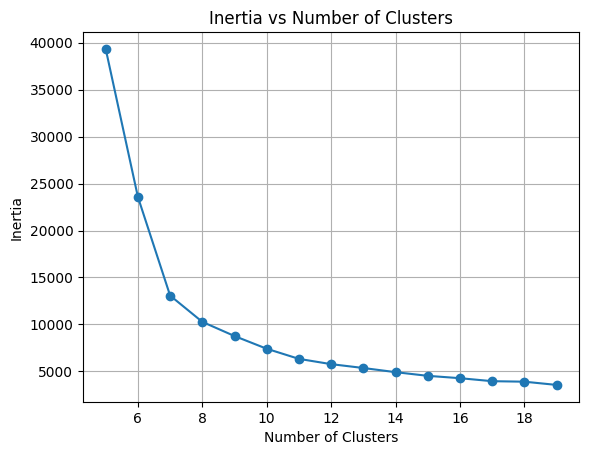

In [6]:
plt.plot(range(5, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.grid(True)
plt.show()

In [7]:
kn = KneeLocator(range(5,20), inertia, curve='convex', direction='decreasing', S=0.001, online = True)
print('Optimal number of clusters:', kn.elbow)

Optimal number of clusters: 8


In [8]:
optimal_k = kn.elbow
kmeans = KMeans(n_clusters=optimal_k,init='k-means++', random_state=42)
clusters = kmeans.fit_predict(features)

user_cluster=user.copy()
user_cluster['Cluster'] = clusters
user_cluster

,IP,Latitude,Longitude,PostCode,City,State,Country,Size,Cluster
0,1.120.0.1,-30.5083,151.6712,2350.0,Armidale,NSW,AU,4075,7
1,1.120.2.1,-37.8833,145.3333,3786.0,Ferny Creek,VIC,AU,1137,3
2,1.120.8.1,-32.2430,148.6048,2830.0,Dubbo,NSW,AU,7443,2
3,1.120.32.1,-37.8141,144.9630,NaN,Melbourne,VIC,AU,10369,3
4,1.120.96.1,-27.4891,153.0188,4101.0,Brisbane,QLD,AU,14674,7
...,...,...,...,...,...,...,...,...,...
4743,220.244.212.1,-38.3613,144.7795,3942.0,Blairgowrie,VIC,AU,6720,3
4744,221.133.209.1,-34.0213,150.8550,NaN,Minto,NaN,AU,14054,2
4745,223.27.177.1,-33.9706,151.2300,NaN,Matraville,NSW,AU,19104,2
4746,223.130.12.1,-33.8660,151.2110,NaN,Sydney,NSW,AU,5411,2


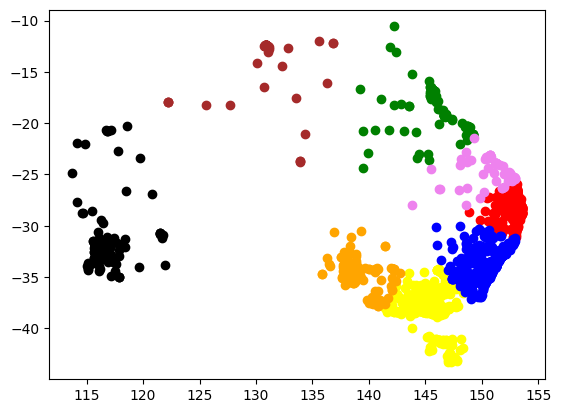

In [9]:
colors=['red','yellow','blue','green','violet','orange','black','brown']
for i,color in zip(user_cluster['Cluster'].unique(),colors):
    cluster_data=user_cluster[user_cluster['Cluster']==i]
    plt.scatter(cluster_data['Longitude'],cluster_data['Latitude'],color=color, label=f'Cluster {i}')


# Single Cluster Unweighted Constrained KMeans

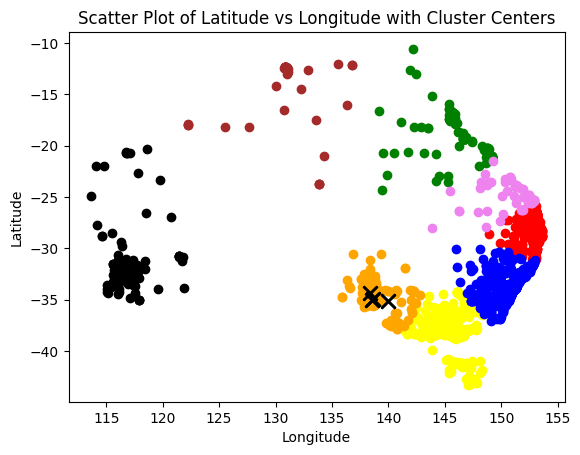

In [10]:
sample=user_cluster[user_cluster['Cluster']==5]
features = sample[['Longitude', 'Latitude']]
kmeans=KMeansConstrained(n_clusters=4,size_max=len(sample)/3.8)
kmeans.fit(features)


colors=['red','yellow','blue','green','violet','orange','black','brown']
for i,color in zip(user_cluster['Cluster'].unique(),colors):
    cluster_data=user_cluster[user_cluster['Cluster']==i]
    plt.scatter(cluster_data['Longitude'],cluster_data['Latitude'],color=color, label=f'Cluster {i}')
for i in range(8):
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black', s=100, label='Cluster Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude vs Longitude with Cluster Centers')
plt.show()

In [11]:
sample['subCluster']=kmeans.labels_
result=sample.groupby(by='subCluster').sum('Size')['Size']
np.std(result)

C:\Users\TRIEU\AppData\Local\Temp\ipykernel_12880\1536436623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['subCluster']=kmeans.labels_


96330.48499955764

# Weighted Constrained Kmeans 

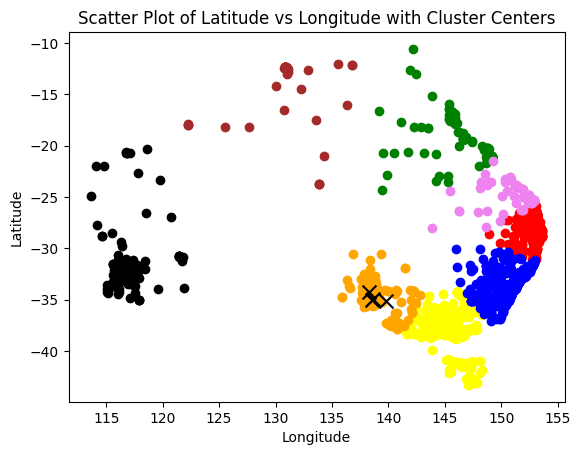

In [12]:
sample=user_cluster[user_cluster['Cluster']==5]
new_list=[]
dup_num=[int(x) for x in round(sample['Size']/1024).tolist()]
for i in range(len(sample)):
    for _ in range(dup_num[i]):
        new_list.append(sample.iloc[i])
new_sample=pd.DataFrame(new_list,columns=sample.columns).reset_index(drop=True)
features = new_sample[['Longitude', 'Latitude']]
#gia su 1 base station cung cap 5000mb/thang
kmeans=KMeansConstrained(n_clusters=4,size_max=np.ceil(len(new_sample)/4))
kmeans.fit(features)

colors=['red','yellow','blue','green','violet','orange','black','brown']
for i,color in zip(user_cluster['Cluster'].unique(),colors):
    cluster_data=user_cluster[user_cluster['Cluster']==i]
    plt.scatter(cluster_data['Longitude'],cluster_data['Latitude'],color=color, label=f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black', s=100, label='Cluster Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude vs Longitude with Cluster Centers')
plt.show()

In [13]:
new_sample['subCluster']=kmeans.labels_
new_sample_2=new_sample.drop_duplicates(subset=['IP'])
result=new_sample_2.groupby(by='subCluster').sum('Size')['Size']
np.std(result)

6128.862883928796

# All Clusters Weighted Constrained Kmeans

In [14]:
new_list=[]
dup_num=[int(x) for x in round(user_cluster['Size']/1024).tolist()]
for i in range(len(user_cluster)):
    for _ in range(dup_num[i]):
        new_list.append(user_cluster.iloc[i])
new_sample=pd.DataFrame(new_list,columns=user_cluster.columns).reset_index(drop=True)

In [15]:
#warning: chay lau vai
new_sample['subCluster']=np.nan
cluster_center_list=[]
total_size_each=user_cluster.groupby(by='Cluster').sum('Size')['Size'].tolist()
for i in range(8):
    single_cluster=new_sample[new_sample['Cluster']==i]
    features = single_cluster[['Longitude', 'Latitude']]
    #gia su 1 base station cung cap 800000mb/thang
    n_clusters=int(np.ceil(total_size_each[i]/800000))
    size_max = np.ceil(len(features) /( n_clusters))
    kmeans=KMeansConstrained(n_clusters=n_clusters,size_max=size_max)
    kmeans.fit(features)
    cluster_center_list.append(kmeans.cluster_centers_)
    new_sample.loc[new_sample['Cluster'] == i, 'subCluster'] = kmeans.labels_
cluster_center_list

[array([[152.24199493, -25.12250121],
        [149.6141954 , -24.26095763]]),
 array([[115.82364409, -31.94570175],
        [115.80605869, -31.82758117],
        [117.24583924, -29.66758814],
        [115.86630394, -31.95280584],
        [116.05162686, -33.06919547],
        [115.84905577, -32.09001489],
        [115.98824234, -31.94453474]]),
 array([[151.19451258, -33.82643943],
        [151.16698236, -33.8813511 ],
        [149.12743528, -35.28937211],
        [151.49283022, -33.17139131],
        [150.89946576, -33.87131193],
        [151.78350208, -32.06211206],
        [151.08115927, -33.9951262 ],
        [151.68498988, -32.91506239],
        [148.91944601, -32.60422074],
        [150.65318936, -34.62706381],
        [151.20946641, -33.85663722],
        [148.73521323, -35.16640039],
        [151.21894527, -33.91253346],
        [151.22571855, -33.78896342],
        [151.20643191, -33.87350363],
        [151.28009092, -33.57264955],
        [149.46942075, -35.6570415 ],
        

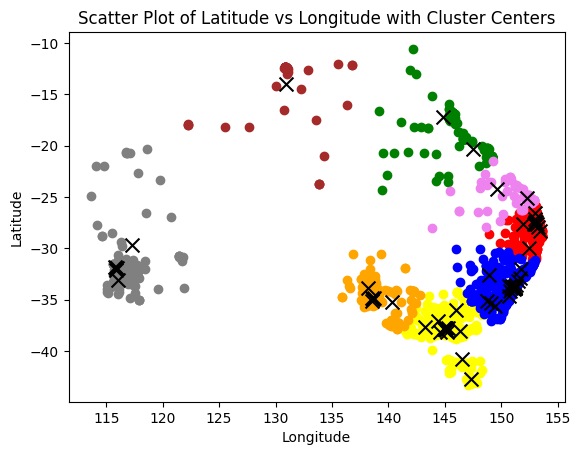

In [16]:
colors=['red','yellow','blue','green','violet','orange','gray','brown']
for i,color in zip(user_cluster['Cluster'].unique(),colors):
    cluster_data=user_cluster[user_cluster['Cluster']==i]
    plt.scatter(cluster_data['Longitude'],cluster_data['Latitude'],color=color, label=f'Cluster {i}')
for i in range(8):
    plt.scatter(cluster_center_list[i][:, 0], cluster_center_list[i][:, 1], marker='x', color='black', s=100, label='Cluster Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude vs Longitude with Cluster Centers')
plt.show()

In [17]:
num_clus=0
for i in cluster_center_list:
    num_clus+=len(i)
num_clus

67

In [18]:
# unique_df=new_sample.drop_duplicates(subset='IP').reset_index(drop=True)
unique_df = pd.read_csv('unique_df.csv')
unique_df

,IP,Latitude,Longitude,PostCode,City,State,Country,Size,Cluster,subCluster
0,1.120.0.1,-30.5083,151.6712,2350.0,Armidale,NSW,AU,4075,7,9.0
1,1.120.2.1,-37.8833,145.3333,3786.0,Ferny Creek,VIC,AU,1137,3,8.0
2,1.120.8.1,-32.2430,148.6048,2830.0,Dubbo,NSW,AU,7443,2,8.0
3,1.120.32.1,-37.8141,144.9630,NaN,Melbourne,VIC,AU,10369,3,0.0
4,1.120.96.1,-27.4891,153.0188,4101.0,Brisbane,QLD,AU,14674,7,1.0
...,...,...,...,...,...,...,...,...,...,...
4743,220.244.212.1,-38.3613,144.7795,3942.0,Blairgowrie,VIC,AU,6720,3,10.0
4744,221.133.209.1,-34.0213,150.8550,NaN,Minto,NaN,AU,14054,2,20.0
4745,223.27.177.1,-33.9706,151.2300,NaN,Matraville,NSW,AU,19104,2,12.0
4746,223.130.12.1,-33.8660,151.2110,NaN,Sydney,NSW,AU,5411,2,10.0


In [19]:
size_list=[]
for i in range(8):
    single_cluster=unique_df[unique_df['Cluster']==i]
    for i in single_cluster.groupby(by='subCluster').sum('Size')['Size'].tolist():
        size_list.append(i)

# Convert to Dataframe and Save to CSV

## No need to care

In [50]:
# import pandas as pd

# # Assume cluster_center_list is a list of arrays, e.g., cluster_center_list[0], cluster_center_list[1], etc.
# # You can modify this according to your actual data structure
# dfs = []
# for i, cluster_center_array in enumerate(cluster_center_list):
#     df = pd.DataFrame(cluster_center_array, columns=['longitude', 'latitude'])
#     dfs.append(df)

# # Concatenate all DataFrames
# result_df = pd.concat(dfs, ignore_index=True)

In [73]:
# df_0 = dfs[0]
# df_1 = dfs[1]
# df_2 = dfs[2]
# df_3 = dfs[3]
# df_4 = dfs[4]
# df_5 = dfs[5]
# df_6 = dfs[6]
# df_7 = dfs[7]

In [141]:
# df_0['Size'] = size_list[:2]
# df_1['Size'] = size_list[2:9]
# df_2['Size'] = size_list[9:31]
# df_3['Size'] = size_list[31:47]
# df_4['Size'] = size_list[47]
# df_5['Size'] = size_list[48:54]
# df_6['Size'] = size_list[54:56]
# df_7['Size'] = size_list[56:68]

In [93]:
# df_0.to_csv('Cluster0.csv',index=False)
# df_1.to_csv('Cluster1.csv',index=False)
# df_2.to_csv('Cluster2.csv',index=False)
# df_3.to_csv('Cluster3.csv',index=False)
# df_4.to_csv('Cluster4.csv',index=False)
# df_5.to_csv('Cluster5.csv',index=False)
# df_6.to_csv('Cluster6.csv',index=False)
# df_7.to_csv('Cluster7.csv',index=False)

In [92]:
# result_df.to_csv('Full_Cluster.csv',index=False)

# Optional

In [116]:
def balance_workload_1(data):
    data_copy = data.copy()
    x = 0
    for i in range(len(data_copy['Size'])):
        if data_copy['Size'].iloc[i] > data_copy['Size'].mean():
            x = data_copy['Size'].iloc[i] - data_copy['Size'].mean()
            data_copy['Size'].iloc[i] = data_copy['Size'].mean()
        elif x != 0 and data_copy['Size'].iloc[i] < data_copy['Size'].mean():
            data_copy['Size'].iloc[i] += x
            x = 0
    return data_copy,data['Size'].mean(),data['Size'].sum()

def balance_workload_2_1(data,mean):
    data_copy = data.copy()
    x = 0
    for i in range(len(data_copy['Size'])):
        if data_copy['Size'].iloc[i] > mean:
            x = data_copy['Size'].iloc[i] - mean
            data_copy['Size'].iloc[i] = mean
        elif x != 0 and data_copy['Size'].iloc[i] < mean:
            data_copy['Size'].iloc[i] += x
            x = 0
    return data_copy

def balance_workload_final_1(data):
    mean = data['Size'].mean()
    a,mean,sum = balance_workload_1(data)
    while not (a[a['Size'] > mean].empty):
        a = balance_workload_2_1(a,mean)
    # a['Size'] = a['Size'].astype('int64')
    x = sum - a['Size'].sum()
    for i in range(len(a['Size'])):
        if x == 0:
            break
        elif a['Size'].iloc[i] < mean:
            tmp = mean-a['Size'].iloc[i]
            a['Size'].iloc[i] += tmp
            x -= tmp
    return a

In [117]:
def balance_workload(data,mean):
    data_copy = data.copy()
    x = 0
    for i in range(len(data_copy['Size'])):
        if data_copy['Size'].iloc[i] > mean:
            x = data_copy['Size'].iloc[i] - mean
            data_copy['Size'].iloc[i] = mean
        elif x != 0 and data_copy['Size'].iloc[i] < mean:
            data_copy['Size'].iloc[i] += x
            x = 0
    sum = data['Size'].sum()
    return data_copy,mean,sum

def balance_workload_2(data,mean):
    data_copy = data.copy()
    x = 0
    for i in range(len(data_copy['Size'])):
        if data_copy['Size'].iloc[i] > mean:
            x = data_copy['Size'].iloc[i] - mean
            data_copy['Size'].iloc[i] = mean
        elif x != 0 and data_copy['Size'].iloc[i] < mean:
            data_copy['Size'].iloc[i] += x
            x = 0
    sum = data['Size'].sum()
    return data_copy,sum

def new_mean(data,mean):
    data_copy = data.copy()
    if data_copy['Size'].mean() > mean:
        new_mean = data_copy['Size'].mean()
    else:
        new_mean = mean
    print(new_mean)
    return new_mean

def balance_workload_final(data):
    a,mean,sum = balance_workload(data,800000)
    while not (a[a['Size'] > mean].empty):
        a,sum = balance_workload_2(a,mean)
    if data['Size'].mean() > mean:
        new_mean = data['Size'].mean()
    else:
        new_mean = mean
    # a['Size'] = a['Size'].astype('int64')
    x = sum - a['Size'].sum()
    for i in range(len(a['Size'])):
        if x == 0:
            break
        elif a['Size'].iloc[i] < mean:
            tmp = mean-a['Size'].iloc[i]
            a['Size'].iloc[i] += tmp
            x -= tmp
    return a,new_mean

In [147]:
df_2['Size'] += 20000

In [148]:
df_2

,longitude,latitude,Size
0,151.194513,-33.826439,983816
1,151.166982,-33.881351,989060
2,149.127435,-35.289372,970980
3,151.492830,-33.171391,988724
4,150.899466,-33.871312,988556
5,151.783502,-32.062112,989692
6,151.081159,-33.995126,1015168
7,151.684990,-32.915062,981657
8,148.919446,-32.604221,965120
9,150.653189,-34.627064,975845


In [149]:
balance,new_mean = balance_workload_final(df_2)
balance_1 = balance_workload_final_1(df_2)

C:\Users\TRIEU\AppData\Local\Temp\ipykernel_12880\824424163.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_copy['Size'].iloc[i] = mean
C:\Users\TRIEU\AppData\Local\Temp\ipykernel_12880\824424163.py:7: SettingWithCopyWarning: 
A val

In [150]:
balance

,longitude,latitude,Size
0,151.194513,-33.826439,800000
1,151.166982,-33.881351,800000
2,149.127435,-35.289372,800000
3,151.492830,-33.171391,800000
4,150.899466,-33.871312,800000
5,151.783502,-32.062112,800000
6,151.081159,-33.995126,800000
7,151.684990,-32.915062,800000
8,148.919446,-32.604221,800000
9,150.653189,-34.627064,800000


In [151]:
balance_1

,longitude,latitude,Size
0,151.194513,-33.826439,988231.181818
1,151.166982,-33.881351,988231.181818
2,149.127435,-35.289372,988231.181818
3,151.492830,-33.171391,988231.181818
4,150.899466,-33.871312,988231.181818
5,151.783502,-32.062112,988231.181818
6,151.081159,-33.995126,988231.181818
7,151.684990,-32.915062,988231.181818
8,148.919446,-32.604221,988231.181818
9,150.653189,-34.627064,988231.181818


In [155]:
new_mean

988231.1818181818

In [156]:
result_df

,longitude,latitude,Size
0,152.241995,-25.122501,428478
1,149.614195,-24.260958,417310
2,115.823644,-31.945702,690207
3,115.806059,-31.827581,701286
4,117.245839,-29.667588,685403
...,...,...,...
62,153.442152,-28.344966,743296
63,152.981675,-27.110599,758702
64,152.871783,-27.630738,734024
65,152.493665,-29.963673,737965


# Visualize

In [16]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import glob

dataset = glob.glob('Cluster*.csv')

mymap = folium.Map(location=[-30.0, 135.0], zoom_start=2)

for data in dataset:
    marker_cluster = MarkerCluster().add_to(mymap)
    new_data = pd.read_csv(data)
    for index, row in new_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=row['Size'] / 50000, 
            color='blue',           
            fill=True,
            fill_color='blue',        
            popup=str(row['Size'])    
        ).add_to(marker_cluster)

In [18]:
mymap